In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import ast
import seaborn as sns

In [2]:
# Load CSV
df = pd.read_csv("../data/data.csv")

# Convert stringified list columns
df['genres'] = df['genres'].apply(ast.literal_eval)
df['privacy_types'] = df['privacy_types'].apply(ast.literal_eval)
df['data_categories'] = df['data_categories'].apply(ast.literal_eval)
df['data_types'] = df['data_types'].apply(ast.literal_eval)


In [3]:
# --- FEATURE ENCODING ---
# Base features
X_feats = pd.DataFrame()
X_feats['price'] = df['price']
X_feats['size'] = df['size']
X_feats['has_in_app_purchases'] = df['has_in_app_purchases'].astype(int)

# One-hot for country and rating
X_feats = pd.concat([
    X_feats,
    pd.get_dummies(df['country_code'], prefix='country'),
    pd.get_dummies(df['content_rating'], prefix='rating')
], axis=1)

In [4]:
# Multi-hot encode genres
mlb_genres = MultiLabelBinarizer()
genres = mlb_genres.fit_transform(df['genres'])
X_feats = pd.concat([X_feats, pd.DataFrame(genres, columns=[f"genre_{g}" for g in mlb_genres.classes_])], axis=1)

In [5]:
# --- LABELS ---
mlb_privacy = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()
mlb_types = MultiLabelBinarizer()

y_privacy = mlb_privacy.fit_transform(df['privacy_types'])
y_categories = mlb_categories.fit_transform(df['data_categories'])
y_types = mlb_types.fit_transform(df['data_types'])

In [6]:
# Combine Step 1 predicted outputs as inputs to Step 2
X_combined = np.concatenate([X_feats, y_privacy, y_categories], axis=1)
print("Combined input shape:", X_combined.shape)

# Normalize
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

Combined input shape: (10000, 83)


In [7]:
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_types, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)


In [8]:
class DataTypePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=34):
        super(DataTypePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [9]:
model = DataTypePredictor(input_dim=X_combined.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

f1_scores = []

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            probs = torch.sigmoid(model(xb))
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}: F1 Score = {f1:.4f}")


Epoch 1: F1 Score = 0.7183
Epoch 2: F1 Score = 0.7725
Epoch 3: F1 Score = 0.8049
Epoch 4: F1 Score = 0.8197
Epoch 5: F1 Score = 0.8323
Epoch 6: F1 Score = 0.8350
Epoch 7: F1 Score = 0.8373
Epoch 8: F1 Score = 0.8388
Epoch 9: F1 Score = 0.8414
Epoch 10: F1 Score = 0.8430
Epoch 11: F1 Score = 0.8415
Epoch 12: F1 Score = 0.8422
Epoch 13: F1 Score = 0.8419
Epoch 14: F1 Score = 0.8435
Epoch 15: F1 Score = 0.8444
Epoch 16: F1 Score = 0.8432
Epoch 17: F1 Score = 0.8427
Epoch 18: F1 Score = 0.8446
Epoch 19: F1 Score = 0.8424
Epoch 20: F1 Score = 0.8453
Epoch 21: F1 Score = 0.8436
Epoch 22: F1 Score = 0.8441
Epoch 23: F1 Score = 0.8464
Epoch 24: F1 Score = 0.8457
Epoch 25: F1 Score = 0.8449
Epoch 26: F1 Score = 0.8440
Epoch 27: F1 Score = 0.8470
Epoch 28: F1 Score = 0.8464
Epoch 29: F1 Score = 0.8463
Epoch 30: F1 Score = 0.8454
Epoch 31: F1 Score = 0.8452
Epoch 32: F1 Score = 0.8467
Epoch 33: F1 Score = 0.8463
Epoch 34: F1 Score = 0.8463
Epoch 35: F1 Score = 0.8469
Epoch 36: F1 Score = 0.8462
E

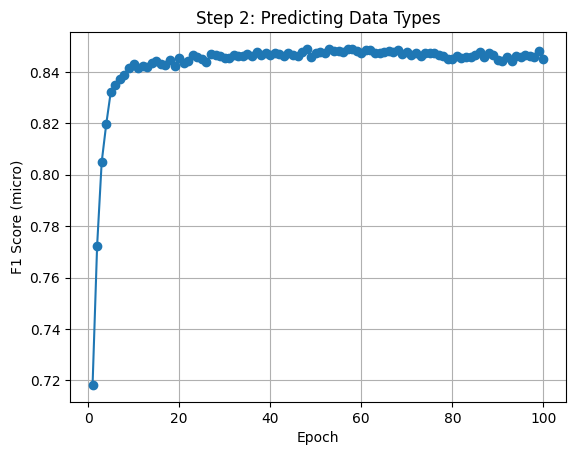

In [10]:
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (micro)")
plt.title("Step 2: Predicting Data Types")
plt.grid(True)
plt.show()


In [11]:
print(classification_report(
    all_true, all_preds, 
    target_names=mlb_types.classes_,
    zero_division=0
))


                         precision    recall  f1-score   support

       Advertising Data       0.75      0.79      0.77       594
             Audio Data       0.50      0.09      0.15        92
       Browsing History       1.00      1.00      1.00        38
        Coarse Location       0.85      0.97      0.90       534
               Contacts       1.00      1.00      1.00        75
             Crash Data       0.96      1.00      0.98      1168
            Credit Info       1.00      0.06      0.12        16
       Customer Support       0.69      0.83      0.76       385
              Device ID       0.88      0.98      0.93       988
          Email Address       0.94      1.00      0.97       601
Emails or Text Messages       0.55      0.11      0.18        57
   Environment Scanning       0.00      0.00      0.00         1
                Fitness       0.69      0.69      0.69        32
       Gameplay Content       0.54      0.34      0.42        97
                  Hands 

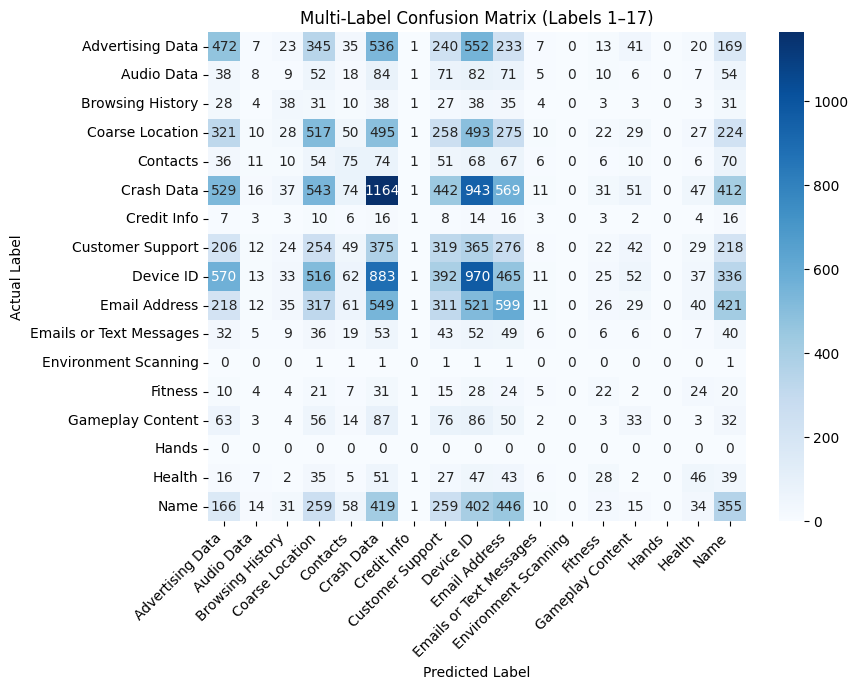

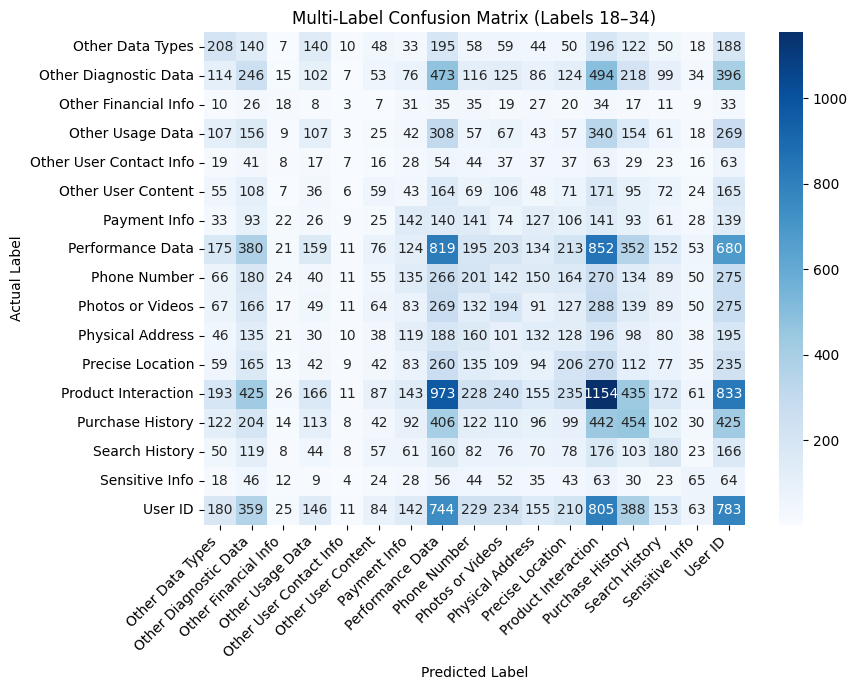

In [15]:
# Full matrix as before
n_labels = len(mlb_types.classes_)
conf_matrix = np.zeros((n_labels, n_labels), dtype=int)

for true_row, pred_row in zip(all_true, all_preds):
    for i in range(n_labels):  # actual
        if true_row[i] == 1:
            for j in range(n_labels):  # predicted
                if pred_row[j] == 1:
                    conf_matrix[i][j] += 1

# Split into two halves
labels = mlb_types.classes_
mid = len(labels) // 2
halves = [(0, mid), (mid, len(labels))]

for idx, (start, end) in enumerate(halves):
    sub_matrix = conf_matrix[start:end, start:end]
    sub_labels = labels[start:end]

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        sub_matrix,
        xticklabels=sub_labels,
        yticklabels=sub_labels,
        cmap="Blues",
        annot=True,
        fmt="d",
        cbar=True
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Multi-Label Confusion Matrix (Labels {start + 1}–{end})")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
